In [184]:
pip install surprise

In [185]:
pip install lightfm

In [186]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity

import os, io
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection.split import train_test_split
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import KNNBasic, KNNWithMeans
from surprise import SVDpp
from surprise import SVD
from surprise import accuracy
from surprise import NMF
from surprise import NormalPredictor, BaselineOnly, KNNWithZScore, KNNBaseline, SVDpp, SlopeOne
import warnings
from wordcloud import WordCloud

from lightfm import LightFM

warnings.filterwarnings("ignore")

In [187]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [188]:
raw_recipes_df = pd.read_csv("/content/drive/Shareddrives/CMPE 256 - Team Project/archive/RAW_recipes.csv")

**Pre Processing of Raw Recipes**

In [189]:
raw_recipes = raw_recipes_df

In [190]:
raw_recipes = raw_recipes.drop(['contributor_id','submitted','tags','steps','description'], axis=1)

In [191]:
raw_recipes[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']] = raw_recipes.nutrition.str.split(",",expand=True) 

In [192]:
raw_recipes.drop('nutrition',axis = 1,inplace=True)

In [193]:
raw_recipes['calories'] = raw_recipes['calories'].map(lambda x: x.lstrip('['))
raw_recipes['carbohydrates'] = raw_recipes['carbohydrates'].map(lambda x: x.rstrip(']'))

In [194]:
raw_recipes['ingredients'] =  raw_recipes.ingredients.apply(lambda x: x.replace(',','').replace('[','').replace(']','').replace("'","").replace('.',''))

In [195]:
text = " ".join(ingredient for ingredient in raw_recipes.ingredients)

In [196]:
wordcloud = WordCloud(width=3000,height=2000,max_words=500).generate(text)

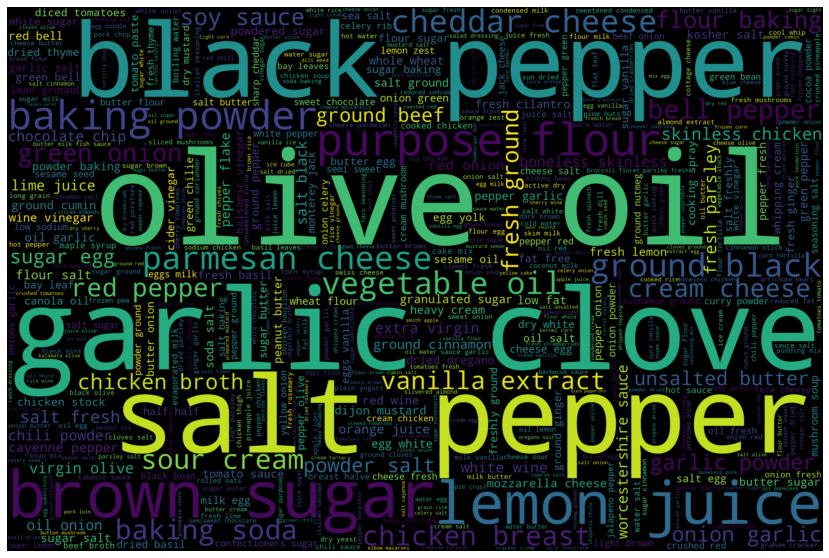

In [197]:
plt.figure(figsize=[15,10]);
plt.imshow(wordcloud, interpolation='bilinear');
plt.axis("off");

In [198]:
wordCounts = WordCloud().process_text(text)

In [199]:
topWordCounts = dict(sorted(wordCounts.items(), key=lambda item: item[1], reverse=True))

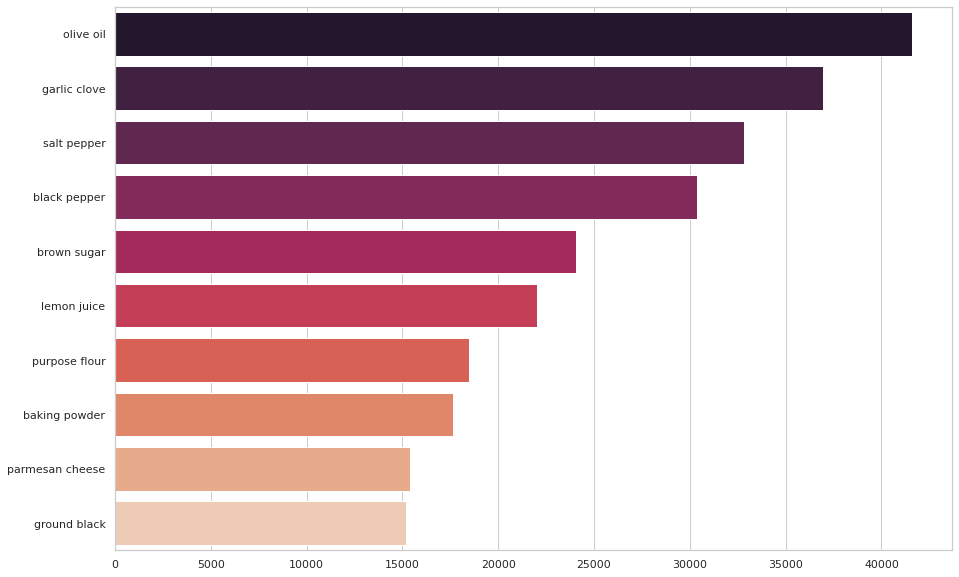

In [200]:
plt.figure(figsize=[15,10]);
sns.barplot(y = list(topWordCounts.keys())[:10], x = list(topWordCounts.values())[:10], palette="rocket")

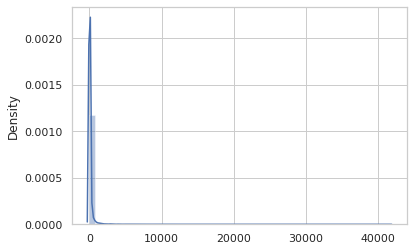

In [201]:
sns.distplot(list(topWordCounts.values()), norm_hist=True)

**Pre Processing of Raw Interactions**

In [202]:
raw_interactions_df = pd.read_csv("/content/drive/Shareddrives/CMPE 256 - Team Project/archive/RAW_interactions.csv")

In [203]:
raw_recipes = raw_recipes.rename({"id":"recipe_id"},axis=1)

In [204]:
train = raw_interactions_df

In [205]:
train = train.merge(raw_interactions_df.drop(["rating","date"],axis=1),on=["user_id","recipe_id"])

In [206]:
train = train.merge(raw_recipes,on=["recipe_id"])

In [207]:
train = train.drop(labels=['user_id'], axis = 1)

In [208]:
train = train.drop_duplicates(subset=['recipe_id'])

In [209]:
train[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']] = train[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']].astype(float)

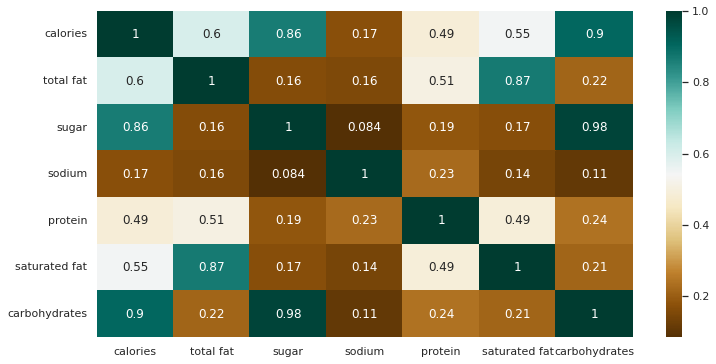

In [210]:
plt.figure (figsize=(12,6))
sns.heatmap(train[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']].corr(), cmap='BrBG', annot=True);

In [211]:
sns.set_theme(style="whitegrid")

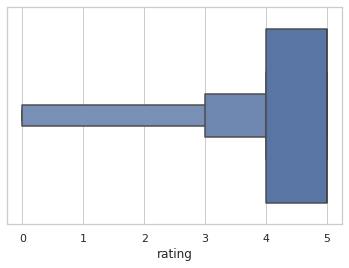

In [212]:
ax = sns.boxenplot(x = train["rating"])

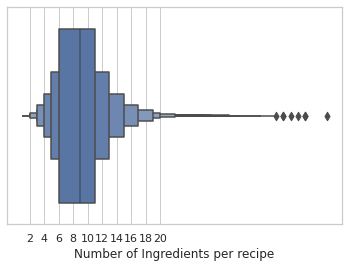

In [213]:
ax = sns.boxenplot(x = train['n_ingredients'])
ax.set_xticks(np.linspace(2,20, 10))
ax.set_xlabel('Number of Ingredients per recipe')
plt.show()

In [214]:
# Dropping the irrelevant columns and considering user_id, recipe_id and ratings
interactions = raw_interactions_df[['user_id', 'recipe_id', 'rating']]

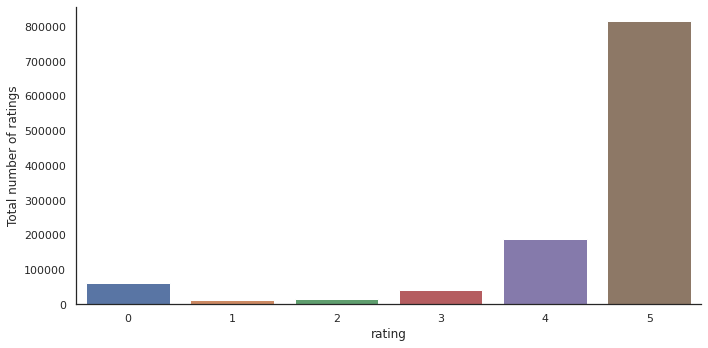

In [215]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=interactions, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

**Unique Users and Products**

In [216]:
print("Total Data ")
print("-"*50)
print("\nTotal no of ratings :",interactions.shape[0])
print("Total No of Users   :", len(np.unique(interactions.user_id)))
print("Total No of Recipes  :", len(np.unique(interactions.recipe_id)))

Total Data 
--------------------------------------------------

Total no of ratings : 1132367
Total No of Users   : 226570
Total No of Recipes  : 231637


**Popularity Based Recommendation**

In [217]:
#Getting the new dataframe which contains users who has given 50 or more ratings
new_df=interactions.groupby("recipe_id").filter(lambda x:x['rating'].count() >=50)

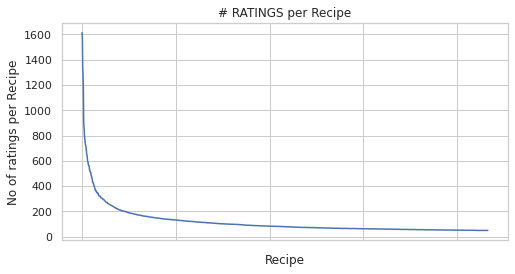

In [218]:
no_of_ratings_per_recipe = new_df.groupby(by='recipe_id')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_recipe.values)
plt.title('# RATINGS per Recipe')
plt.xlabel('Recipe')
plt.ylabel('No of ratings per Recipe')
ax.set_xticklabels([])

plt.show()

In [219]:
#Average rating of the Recipes 
new_df.groupby('recipe_id')['rating'].mean()

recipe_id
246       4.615385
536       3.984848
607       4.074830
632       4.349398
749       4.378947
            ...   
505862    3.787879
508302    3.000000
514605    4.339623
515167    4.932432
524863    4.900000
Name: rating, Length: 2164, dtype: float64

In [220]:
new_df.groupby('recipe_id')['rating'].mean().sort_values(ascending=False).head()

recipe_id
55309     5.000000
486261    4.990783
42038     4.964912
21033     4.963636
248495    4.962264
Name: rating, dtype: float64

In [221]:
#Total no of rating for Recipe

new_df.groupby('recipe_id')['rating'].count().sort_values(ascending=False).head()

recipe_id
2886     1613
27208    1601
89204    1579
39087    1448
67256    1322
Name: rating, dtype: int64

In [222]:
ratings_mean_count = pd.DataFrame(new_df.groupby('recipe_id')['rating'].mean())

In [223]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('recipe_id')['rating'].count())

In [224]:
ratings_mean_count

,rating,rating_counts
recipe_id,,
246,4.615385,65
536,3.984848,66
607,4.074830,147
632,4.349398,83
749,4.378947,190
...,...,...
505862,3.787879,66
508302,3.000000,51
514605,4.339623,53


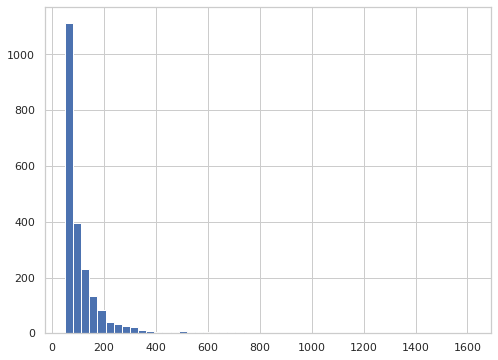

In [225]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

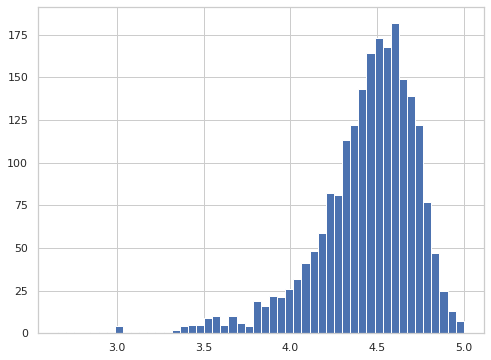

In [226]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

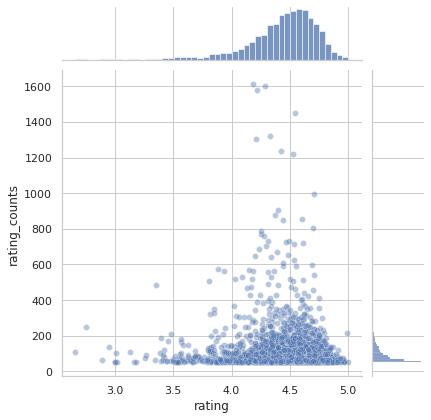

In [227]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

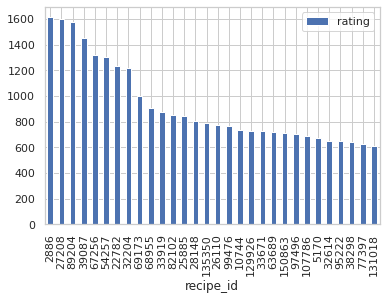

In [228]:
popular_recipes = pd.DataFrame(new_df.groupby('recipe_id')['rating'].count())
most_popular = popular_recipes.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

**Collaberative filtering (Item-Item recommedation)**

In [229]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [230]:
#Reading the dataset
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(new_df,reader)

In [231]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [232]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
knn_means= KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
knn_means.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [233]:
# run the trained model against the testset
test_pred = knn_means.test(testset)

In [234]:
# get RMSE KNN
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3713


1.3712782587047438

In [235]:
svd = SVD(verbose=False, n_factors=3, reg_all=0.1, n_epochs=25)
svd.fit(trainset)

In [236]:
test_pred_svd = svd.test(testset)

In [237]:
accuracy.rmse(test_pred_svd, verbose=True)

RMSE: 1.2766


1.2765875959134352

**Model-based collaborative filtering system**

In [238]:
#new_df1=new_df.head(100000)
ratings_matrix = new_df.pivot_table(values='rating', index='user_id', columns='recipe_id', fill_value=0)

recipe_id,246,536,607,632,749,809,822,860,916,1005,1035,1356,1600,1985,2072,2267,2496,2498,2510,2537,2677,2708,2791,2886,3091,3092,3157,3166,3180,3370,3470,3579,3595,3603,3745,3929,3954,4050,4065,4075,...,373619,380988,384800,393491,393523,411045,411501,411689,418682,434863,438883,443758,443987,449378,449452,462563,472445,474520,474987,486261,486267,486496,486641,491126,491858,493413,494435,494438,495271,495275,495577,496614,497021,500210,501408,505862,508302,514605,515167,524863
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1533,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1535,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1634,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1755,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002370573,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2002370607,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2002371157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [239]:
X = ratings_matrix.T

In [240]:
X1 = X

In [241]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(2164, 10)

In [242]:
#Correlation Matrix
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(2164, 2164)

In [243]:
X.index[75]

8509

In [244]:
i = 8509

recipe_names = list(X.index)
recipe_ID = recipe_names.index(i)
recipe_ID

75

In [245]:
correlation_recipe_id = correlation_matrix[recipe_ID]

In [246]:
Recommend = list(X.index[correlation_recipe_id > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

[246,
 536,
 607,
 632,
 749,
 809,
 822,
 860,
 916,
 1005,
 1035,
 1356,
 1600,
 1985,
 2072,
 2267,
 2496,
 2498,
 2510,
 2537,
 2677,
 2708,
 2791,
 3091]

# LightFM

In [247]:
raw_recipes_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [248]:
raw_interactions_df

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...


In [249]:
recipes_metadata = raw_recipes_df[['id', 'minutes', 'n_steps', 'n_ingredients']]

In [250]:
recipes_metadata

,id,minutes,n_steps,n_ingredients
0,137739,55,11,7
1,31490,30,9,6
2,112140,130,6,13
3,59389,45,11,11
4,44061,190,5,8
...,...,...,...,...
231632,486161,60,7,22
231633,493372,5,1,13
231634,308080,40,7,8
231635,298512,29,9,10


In [251]:
recipe_dict ={}

In [252]:
df = raw_recipes_df[['id', 'name']].sort_values('id').reset_index()

In [253]:
df

,index,id,name
0,126987,38,low fat berry blue frozen dessert
1,23695,39,biryani
2,22701,40,best lemonade
3,36412,41,carina s tofu vegetable kebabs
4,22217,43,best blackbottom pie
...,...,...,...
231632,13104,537459,bailey s chocotini
231633,1547,537485,5 ingredient salted caramel crumble bars
231634,137661,537543,moist gingerbread cake
231635,145532,537671,nutcracker peppermint red velvet cake pops


In [254]:
for i in range(df.shape[0]):
    recipe_dict[(df.loc[i,'id'])] = df.loc[i,'name']

In [255]:
# dummify categorical features
recipe_metadata_transformed = pd.get_dummies(recipes_metadata, columns = ['minutes', 'n_steps', 'n_ingredients'])
recipe_metadata_transformed = recipe_metadata_transformed.sort_values('id').reset_index().drop('index', axis=1)
recipe_metadata_transformed.head(5)

,id,minutes_0,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22,minutes_23,minutes_24,minutes_25,minutes_26,minutes_27,minutes_28,minutes_29,minutes_30,minutes_31,minutes_32,minutes_33,minutes_34,minutes_35,minutes_36,minutes_37,minutes_38,...,n_ingredients_2,n_ingredients_3,n_ingredients_4,n_ingredients_5,n_ingredients_6,n_ingredients_7,n_ingredients_8,n_ingredients_9,n_ingredients_10,n_ingredients_11,n_ingredients_12,n_ingredients_13,n_ingredients_14,n_ingredients_15,n_ingredients_16,n_ingredients_17,n_ingredients_18,n_ingredients_19,n_ingredients_20,n_ingredients_21,n_ingredients_22,n_ingredients_23,n_ingredients_24,n_ingredients_25,n_ingredients_26,n_ingredients_27,n_ingredients_28,n_ingredients_29,n_ingredients_30,n_ingredients_31,n_ingredients_32,n_ingredients_33,n_ingredients_34,n_ingredients_35,n_ingredients_36,n_ingredients_37,n_ingredients_38,n_ingredients_39,n_ingredients_40,n_ingredients_43
0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [256]:
from scipy.sparse import csr_matrix

In [257]:
# convert to csr matrix
recipe_metadata_csr = csr_matrix(recipe_metadata_transformed.drop('id', axis=1).values)

In [258]:
user_id = list(ratings_matrix.index)

In [259]:
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

In [260]:
# convert to csr matrix
user_recipe_interaction_csr = csr_matrix(ratings_matrix.values)

In [261]:
model = LightFM(loss='warp',
                random_state=2016,
                learning_rate=0.90,
                no_components=30,
                user_alpha=0.000005)

In [262]:
model = model.fit(user_recipe_interaction_csr,
                  epochs=20,
                  num_threads=16, verbose=False)

In [283]:
def recommendation(model, interactions, user_id, user_dict, 
                               recipe_dict,threshold = 0, num_items = 10, show = True):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    predictions = pd.Series(model.predict(user_x,np.arange(n_items), item_features=recipe_metadata_csr))
    predictions.index = interactions.columns
    predictions = list(pd.Series(predictions.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    predictions = [x for x in predictions if x not in known_items]
    return_pred_list = predictions[0:num_items]
    known_items = list(pd.Series(known_items).apply(lambda x: recipe_dict[x]))
    predictions = list(pd.Series(return_pred_list).apply(lambda x: recipe_dict[x]))
    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1
    print("\n Recommended Items:")
    counter = 1
    for i in predictions:
      print(str(counter) + '- ' + i)
      counter+=1

In [284]:
recommendation(model, ratings_matrix, 1533, user_dict, recipe_dict)

User: 1533
Known Likes:
1- best vegan ranch dressing
2- uncle bill s hamburger patties
3- uncle bill s whipped shortbread cookies
4- chicken garlic bites

 Recommended Items:
1- patti labelle s macaroni and cheese
2- soft peanut butter cookies
3- stupid easy 3 ingredient nacho dip
4- yes  virginia there is a great meatloaf
5- sore and strep throat away gargle
6- papa john s pizza sauce
7- andes crme de menthe cookies   andes mint cookies
8- cheesy garlic pull aparts
9- traditional english cheddar cauliflower cheese   gratin
10- amazing white trash puff balls


# Recommendations of recipes by taking into account user's nutritional value preferences and user's list of ingredients.

In [285]:
raw_interactions = raw_interactions_df

In [286]:
raw_interactions = raw_interactions.drop(['date'], axis = 1)

In [287]:
raw_recipes = raw_recipes_df

In [288]:
raw_recipes = raw_recipes.drop(['contributor_id','submitted','tags','steps','description'], axis=1)

In [289]:
raw_recipes[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']] = raw_recipes.nutrition.str.split(",",expand=True)

In [290]:
raw_recipes.drop('nutrition',axis = 1,inplace=True)

In [291]:
raw_recipes['calories'] = raw_recipes['calories'].map(lambda x: x.lstrip('['))
raw_recipes['carbohydrates'] = raw_recipes['carbohydrates'].map(lambda x: x.rstrip(']'))

In [292]:
raw_recipes['ingredients'] =  raw_recipes.ingredients.apply(lambda x: x.replace(',','').replace('[','').replace(']','').replace("'","").replace('.',''))

In [293]:
text = " ".join(ingredient for ingredient in raw_recipes.ingredients)

In [294]:
raw_recipes = raw_recipes.rename({"id":"recipe_id"},axis=1)

In [295]:
temp = raw_recipes.merge(raw_interactions, on=['recipe_id'])

In [296]:
temp = temp.drop(['user_id'], axis = 1)

In [297]:
df = temp.drop_duplicates(subset=['recipe_id'])

In [298]:
df = df.drop(['rating', 'review'], axis = 1)

In [299]:
df.dropna(inplace=True)

In [302]:
df[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']] = df[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']].astype(float)

In [303]:
df.head()

,name,recipe_id,minutes,n_steps,ingredients,n_ingredients,calories,total fat,sugar,sodium,protein,saturated fat,carbohydrates
0,arriba baked winter squash mexican style,137739,55,11,winter squash mexican seasoning mixed spice ho...,7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
3,a bit different breakfast pizza,31490,30,9,prepared pizza crust sausage patty eggs milk s...,6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
7,all in the kitchen chili,112140,130,6,ground beef yellow onions diced tomatoes tomat...,13,269.8,22.0,32.0,48.0,39.0,27.0,5.0
8,alouette potatoes,59389,45,11,spreadable cheese with garlic and herbs new po...,11,368.1,17.0,10.0,2.0,14.0,8.0,20.0
10,amish tomato ketchup for canning,44061,190,5,tomato juice apple cider vinegar sugar salt pe...,8,352.9,1.0,337.0,23.0,3.0,0.0,28.0


In [304]:
#@title Do you want to select nutritional values?

dropdown = 'Yes' #@param ["No", "Yes"]

In [305]:
#@title Please select nutritional values required.


calorie = 150 #@param {type:"slider", min:0, max:550, step:10}
fat = 9 #@param {type:"slider", min:0, max:50, step:1}
sugar = 37 #@param {type:"slider", min:0, max:80, step:1}
sodium = 14 #@param {type:"slider", min:0, max:40, step:1}
protein = 36 #@param {type:"slider", min:0, max:60, step:1}
saturated_fat = 11 #@param {type:"slider", min:0, max:60, step:1}
carbs = 11 #@param {type:"slider", min:0, max:20, step:1}

In [306]:
#@title Enter ingredients separated with a space

input = 'ground chicken red bell pepper onion garlic cloves fresh ginger fresh lemon juice hoisin sauce brown sugar sesame' #@param {type:"string"}
print(input)

ground chicken red bell pepper onion garlic cloves fresh ginger fresh lemon juice hoisin sauce brown sugar sesame


In [307]:
if dropdown == 'Yes':
  trial = df[df['sugar'].between(sugar-10,sugar+10, inclusive = True)]
  trial = trial[trial['sodium'].between(sodium-10,sodium+10, inclusive = True)]
  trial = trial[trial['total fat'].between(fat-10,fat+10, inclusive = True)]
  trial = trial[trial['protein'].between(protein-10,protein+10, inclusive = True)]
  trial = trial[trial['saturated fat'].between(saturated_fat-10,saturated_fat+10, inclusive = True)]
  trial = trial[trial['carbohydrates'].between(carbs-10,carbs+10, inclusive = True)]
  trial = trial[trial['calories'].between(calorie-10,calorie+10, inclusive = True)]

else:
  trial = df.sample(100000)

In [308]:
ing = trial.ingredients.to_list()

In [309]:
ing.append(input)

In [310]:
ing

['ground chicken red bell pepper onion garlic cloves fresh ginger fresh lemon juice hoisin sauce brown sugar sesame oil low sodium soy sauce pepper sauce cilantro iceberg lettuce',
 'mahi mahi fillets lemon juice butter ground ginger salt pepper paprika orange slices crushed pineapple',
 'orange boneless skinless chicken breast soy sauce dry sherry green onions gingerroot cornstarch sugar salt orange juice salad oil red pepper',
 'bacon onion celery red bell pepper garlic fresh thyme flour chicken broth fat-free evaporated milk diced tomatoes cream-style corn roasted chicken breast barbecue sauce black pepper salt',
 'salmon spinach mushroom lemon juice nonfat plain yogurt fat-free ricotta cheese cilantro garlic egg white cayenne pepper salt and pepper',
 'gnocchi olive oil onion garlic crushed tomatoes clams fresh basil',
 'olive oil mushrooms onion green bell pepper celery carrot garlic cloves lean ground turkey ketchup red wine vinegar worcestershire sauce dried oregano salt ground 

In [311]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')

tfidf_matrix = tf.fit_transform(ing)

print((tfidf_matrix.shape))

(24, 951)


In [312]:
sim = cosine_similarity(tfidf_matrix[-1], tfidf_matrix)[0]
sim= list(sim)

In [313]:
test1 = sorted(sim)[::-1][1:6]

In [314]:
c = []
for i in test1:
  c.append(sim.index(i))

In [315]:
trial.iloc[c,:] #recommended recipes

,name,recipe_id,minutes,n_steps,ingredients,n_ingredients,calories,total fat,sugar,sodium,protein,saturated fat,carbohydrates
45560,asian chicken and lettuce wraps,386928,25,10,ground chicken red bell pepper onion garlic cl...,13,146.8,6.0,35.0,10.0,28.0,3.0,4.0
1019831,thai steak salad with basil and mint,470179,40,13,sugar fresh lime juice fish sauce water thai c...,16,157.7,7.0,46.0,19.0,26.0,9.0,5.0
610380,lemon chicken breasts low fat,166783,60,17,boneless skinless chicken breasts cornstarch s...,16,144.9,4.0,31.0,19.0,27.0,4.0,5.0
518266,hidden veggie sloppy joes,433060,40,7,olive oil mushrooms onion green bell pepper ce...,15,142.6,8.0,27.0,11.0,26.0,6.0,3.0
642805,mahi mahi polynesian style,24983,55,10,mahi mahi fillet soy sauce pineapple chunks in...,10,150.6,1.0,41.0,14.0,44.0,1.0,4.0
